# Analysis of in-silico amino-acid mutations of PSD95$^{\text{pdz3}}$

## Set-up the calculation

In [1]:
import sys
import os
import tools.structure_analysis_tools as sa
import tools.sidechain_length as scl
import tools.amino_acids_conversion as aac
import tools.helpers as helpers

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
import matplotlib as mpl
import pickle
import pandas as pd
import csv
import numpy as np
from shutil import copyfile
import numpy as np
import glob
from collections import OrderedDict
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

In [2]:
# Read configuration file
config_file = "config.json"
parameters = helpers.get_configuration_parameters(config_file)

In [3]:
name = parameters['name']
cutoff = parameters["cutoff"]
dim = parameters["dim"]
if dim == "all":
    dim = ""
rel_list = sa.list_relations(dim)
pdb_wt = parameters['pdb_wt']
pdbs_mut = parameters['pdbs_mut_path']
select_positions = parameters["select_positions"]
if select_positions:
    start = parameters["start"]
    stop = parameters["stop"]
    selected_positions = range(start, stop)
else:
    selected_positions = None
selected_chains = parameters["selected_chains"]
if selected_chains == "all":
    selected_chains = None

folder_path = os.path.join("results", name, dim)
os.makedirs(folder_path, exist_ok=True)

helpers.save_configuration_parameters(config_file, folder_path)

for k, v in parameters.items():
    print(k, "\t", v)

name 	 1be9_Repair_matrix_GCAT_all
pdb_wt 	 1be9_Repair
pdbs_wt_path 	 None
pdbs_mut_path 	 1be9_Repair_pdbs_mutants
select_positions 	 False
start 	 None
stop 	 None
selected_chains 	 A
cutoff 	 5
dim 	 all


In [4]:
pdbs = [os.path.split(pdb)[1].split('.')[0] for pdb in glob.glob(os.path.join("data", pdbs_mut, '*'))]
if selected_positions:
    pdbs = [p for p in pdbs if int(p[5:-1]) in selected_positions]

In [5]:
schl_dict = scl.dict_classif

In [6]:
if "1be9" in name:
    fsp = ['A323', 'A324', 'A325', 'A327', 'A328', 'A329', 'A330', 'A336', 'A338', 'A341', 'A347',
           'A353', 'A359','A362', 'A367', 'A372', 'A375', 'A376', 'A379', 'A388']
    surface = ['A301', 'A302', 'A304', 'A305', 'A306', 'A308','A309', 'A310',
               'A311', 'A313', 'A315', 'A317', 'A319', 'A320', 'A321',
               'A322', 'A326', 'A331', 'A332', 'A333', 'A334', 'A340', 'A342',
               'A343', 'A344', 'A349', 'A350', 'A351', 'A352', 'A354', 'A355',
               'A363', 'A364', 'A365', 'A366', 'A368', 'A369', 'A371', 'A373',
               'A374', 'A377', 'A380', 'A381', 'A383', 'A384', 'A385', 'A387',
               'A389', 'A393', 'A395', 'A396', 'A399', 'A400', 'A401', 'A402',
              'A403', 'A405', 'A406', 'A407', 'A408', 'A411', 'A413', 'A414','A415']
#     ASA = pd.read_csv(os.path.join(data_folder, "1be9_ASA.csv"))
#     ASA = ASA[ASA.CH == "A"]
#     ASA["Residue"] = ASA.CH + ASA.No.astype(str)

## Classification of in-silico amino-acid mutations based on the scale of neighborhoods rearrangement they provoke

Nineteen mutant structures are produced in silico for each amino acid of PSD95$^{\text{pdz3}}$ (positions 301 to 415, resulting in a total of 2185 mutant structures). Then, the Amino Acid Network (AAN) of each mutant is built and compared with the WT AAN.

For each mutant structure resulting from the mutation of an amino acid at position $i$, the set of perturbed amino acid positions is defined as the set of amino acids whose nodes in the AAN have a different neighborhood compared to the WT AAN. The neighborhood of an amino acid is considered to be different if the amino acid has gained or lost one or more links (i.e. it has gained or lost neighbors). If an amino acid changes link weights with its neighbors but it does not change its set of neighbors, we consider its neighborhood to be unchanged, i.e. the amino acid is not perturbed by the mutation.

Based on the set of perturbed amino acids, the mutations $i \rightarrow i'$ are classified as follows:

- Zero (Z) rearrangement if no amino acid is changes neighborhood;
- Local (L) rearrangement if only first-shell neighbors of $i$ change neighborhood. These mutations are further classified as:
  - Ll if $i$ loses first neighbors upon mutation;
  - Lg if $i$ gains first neighbors upon mutation (or loses some neighbors and gains others);
  - Lw if $i$ does not change neighbors but the connectivity among its first neighbors changes. This implies atomic rearrangement but without the gain or loss of amino-acid contacts at the $i$ position.
- Far (F) rearrangement if nodes that are further from the first-shell neighborhood of $i$ are perturbed. These mutations are further classified as:
  - Fw if node $i$ does not change neighborhood (the perturbation spreads through changes in link weights).
  - Fk if node $i$ changes neighborhood and a path of neighborhood changes connects $i$ with all perturbed nodes (the perturbation spreads through changes in neighborhoods);
  - Fkw if node $i$ changes neighborhood but not all perturbed nodes are connected by a path of perturbations to node $i$ (the perturbation spreads through changes in neighborhoods and changes in weight).

In [7]:
wtnet, node_labels = sa.create_aa_network(pdb_wt, rel_list,
                                            folder_path,
                                            selected_positions,
                                            selected_chains,
                                            cutoff=cutoff,
                                            remove_hydrogen_atoms=False)

seq = list(wtnet.nodes)
N = len(seq)

In [8]:
allP = {}
for pdb in pdbs:
    changes = {node: {y: [] for y in ['plus', 'minus', 'tot']} for node in seq}
        
    net, _ = sa.create_aa_network(pdb, rel_list,
                                    folder_path,
                                    selected_positions,
                                    selected_chains,
                                    cutoff=cutoff,
                                    remove_hydrogen_atoms=False,
                                    pdbs_path=pdbs_mut)
    for n in net.nodes:

        neighs = set(net.neighbors(n))
        wtneighs = set(wtnet.neighbors(n))

        diffplus = neighs - wtneighs
        diffminus = wtneighs - neighs
        inters = neighs.intersection(wtneighs)

        for v in diffplus:
            changes[n]['plus'] += [v]
            changes[n]['tot'] += [v]
        for v in diffminus:
            changes[n]['minus'] += [v]
            changes[n]['tot'] += [v]
    
    P = {n: changes[n] for n in changes if len(changes[n]['tot']) > 0 }
    allP[pdb] = P

Type 1 subgraph :
- Nodes: perturbed nodes and the source (even if not perturbed);
- Links: between nodes that are first neighbors in the WT AAN.

Type 2 subgraph:
- Nodes: perturbed nodes; 
- Links: lost or gained interactions.

In [9]:
subgraphs_folder_type2 = os.path.join(folder_path, "subgraphs_type2")
os.makedirs(subgraphs_folder_type2, exist_ok=True)
subgraphs_folder_type1 = os.path.join(folder_path, "subgraphs_type1")
os.makedirs(subgraphs_folder_type1, exist_ok=True)

In [10]:
def source_pert(pdb):
    v = 'A' + pdb[5:-1]
    return v

In [11]:
pert_dict = {}
for pdb in pdbs:
    if pdb in allP:
        P = allP[pdb]

        source = source_pert(pdb)
        first_neighs_source = list(wtnet.neighbors(source))

        net_type2 = nx.Graph()
        net_type1 = nx.Graph()

        pert_nodes = {n for n in P.keys() if len(P[n]['tot']) > 0}
        net_type2.add_nodes_from(pert_nodes)
        net_type1.add_nodes_from(pert_nodes)

        node_color_type2 = []
        node_color_type1 = []

        for n in pert_nodes:
            pert = len(np.array(P[n]['tot']))
            pert_neighs = P[n]['tot']
            firstneighs = set(wtnet.neighbors(n)).intersection(set(pert_nodes).union(source))
            for neigh in pert_neighs:
                net_type2.add_edge(n, neigh)
            for neigh in firstneighs:
                net_type1.add_edge(n, neigh)

        for n in net_type2.nodes:
            if n == source:
                node_color_type2.append('r')
            else:
                node_color_type2.append('w')

        for n in net_type1.nodes:
            if n == source:
                node_color_type1.append('r')
            else:
                node_color_type1.append('w')

        if len(pert_nodes) >  0: # not ZERO
            # check if the perturbed nodes are first neighbors of the source in the WT
            # (or are the source):
            if set(pert_nodes).intersection(set(first_neighs_source).union(set([source]))) == set(pert_nodes):
                if source in pert_nodes:
                    pert_dict[pdb] = "Ll"
                else:
                    pert_dict[pdb] = "Lw"

            else:
                # check distance from source in the network of type 2
                try:
                    distances = nx.shortest_path_length(net_type2, source=source)
                    if set(distances.keys()) == set(net_type2.nodes): # check if connected
                        maxdist = max(distances.values())
                        if maxdist == 1:
                            pert_dict[pdb] = "Lg"
                        else:
                            pert_dict[pdb] = "Fk"
                    else:
                        pert_dict[pdb] = "Fkw"
                except:
                    pert_dict[pdb] = "Fw"

        else:
            pert_dict[pdb] = "Z"


        if len(net_type2.nodes) > 0:
            subgraphs_path_type2 = os.path.join(subgraphs_folder_type2, pdb + '.pdf')
            scale = 0.5
            k = None

            pos = nx.spring_layout(net_type2, k=k, scale=scale)
            nx.draw_networkx(net_type2, pos=pos, with_labels=True, node_color=node_color_type2,
                             edgecolors='k', font_size=7)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(subgraphs_path_type2)
            plt.clf()

        if len(net_type1.nodes) > 0:
            subgraphs_path_type1 = os.path.join(subgraphs_folder_type1, pdb + '.pdf')
            scale = 0.5
            k = None
            pos = nx.spring_layout(net_type1, k=k, scale=scale)
            nx.draw_networkx(net_type1, pos=pos, with_labels=True, node_color=node_color_type1,
                             edgecolors='k', font_size=7)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(subgraphs_path_type1)
            plt.clf()

<Figure size 432x288 with 0 Axes>

In [12]:
amino_acids = sa.list_aa(sort_by_sidechain=True)

In [13]:
schl_dict_num = scl.dict_size

In [14]:
M = {p: OrderedDict({aa: np.nan for aa in amino_acids}) for p in seq}
Mn = {p: OrderedDict({aa: -1 for aa in amino_acids}) for p in seq}
Mdist = {p: OrderedDict({aa: 0 for aa in amino_acids}) for p in seq}

for pdb in pdbs:
    pos = pdb[5:-1]
    aa_wt = pdb[4]
    aa_mut = pdb[-1]
    schl_wt = schl_dict_num[aa_wt]
    schl_mut = schl_dict_num[aa_mut]
    dist = round(schl_mut - schl_wt)
    if int(pos) < 300:
        pos = "B" + pos
    else:
        pos = "A" + pos
    mut = aac.one2three(aa_mut)
    pert = pert_dict[pdb]
    if pert == "Fk":
        pertn = 6
    elif pert == "Fkw":
        pertn = 5
    elif pert == "Fw":
        pertn = 4
    elif pert == "Lg":
        pertn = 3
    elif pert == "Lw":
        pertn = 2
    elif pert == "Ll":
        pertn = 1
    else:
        pertn = 0
    M[pos][mut] = pert
    Mn[pos][mut] = pertn
    Mdist[pos][mut] = dist

In [15]:
M = pd.DataFrame(M, index=amino_acids)
Mn = pd.DataFrame(Mn, index=amino_acids)
Mdist = pd.DataFrame(Mdist, index=amino_acids)

In [16]:
M_approx = M.replace(["Fw", "Fk", "Fkw"], "F").replace(["Lw", "Lg", "Ll"], "L")

In [17]:
M_approx_describe = M_approx.describe()

Classify positions as Z, L, F if at least 17 mutations are Z, L, F, otherwise, classify as M

In [18]:
M_approx_describe.loc["class"] = np.where(M_approx_describe.loc["freq"] > 16, M_approx_describe.loc["top"], "M")

In [19]:
M_approx_describe

,A301,A302,A303,A304,A305,A306,A307,A308,A309,A310,...,A406,A407,A408,A409,A410,A411,A412,A413,A414,A415
count,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
unique,2,2,3,2,2,3,3,3,2,2,...,2,3,3,3,1,1,3,3,3,3
top,Z,Z,F,Z,L,L,F,Z,F,Z,...,Z,F,Z,F,F,L,L,F,L,Z
freq,17,18,10,13,18,11,14,15,18,13,...,11,12,11,8,19,19,15,8,7,17
class,Z,Z,M,M,L,M,M,M,F,M,...,M,M,M,M,F,L,M,M,M,Z


In [20]:
M_approx_describe.loc['class'].value_counts()

M    75
Z    22
L    11
F     7
Name: class, dtype: int64

In [21]:
buried = sorted(set(seq) - set(surface), key= lambda x:x[1::])

In [22]:
aaseq = [n[0:-2] for n in node_labels.values()]
aaseq_surf = [node_labels[n][0:-2] for n in surface]
aaseq_buried = [node_labels[n][0:-2] for n in buried]

In [23]:
cmap = ListedColormap(['w', 'y', 'g', 'c', 'b', 'm', 'r'])

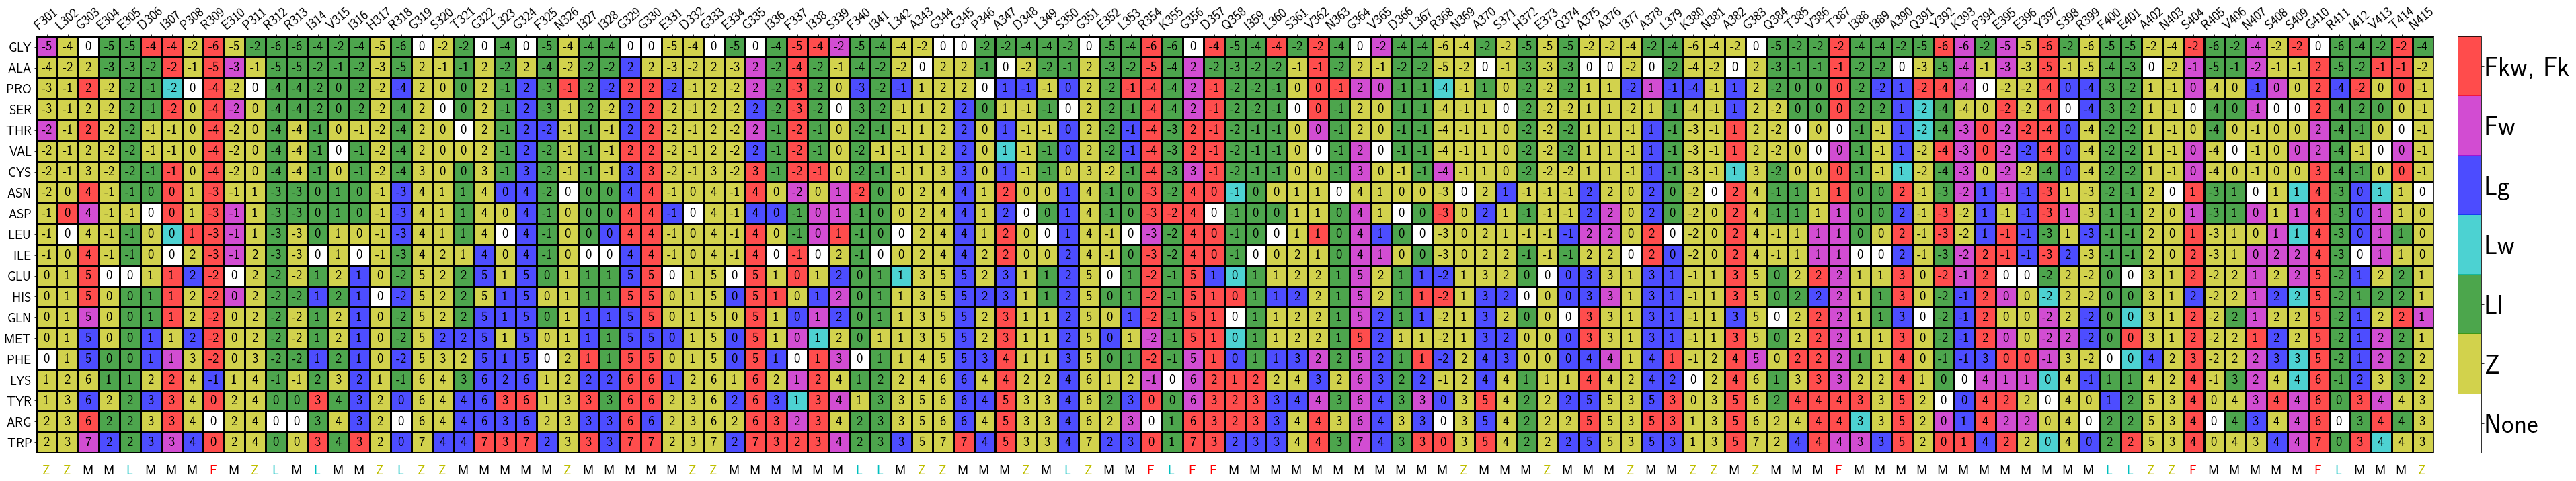

In [24]:
fig, ax = plt.subplots(figsize=(60, 10))
im = ax.imshow(Mn.values, cmap=cmap, alpha=0.7)


# Loop over data dimensions and create text annotations.
for i in range(len(Mdist.values)):
    for j in range(len(Mdist.values[i])):
        if M.to_numpy()[i][j]:
            text = ax.text(j, i, Mdist.values[i, j],
                           ha="center", va="center", color="k", fontsize=20)


ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=20)

ax.set_xticks(np.arange(Mn.values.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(Mn.values.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="k", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=.5)

values=np.arange(-.5, 6, 1)
cbar = fig.colorbar(im, cax=cax, ticks=values)

cbar.ax.set_yticklabels(["None", "Z", "Ll", "Lw", "Lg", "Fw", "Fkw, Fk"], fontsize=40)
ax.set_xticks(range(len(Mn.columns)))
ax.set_xticklabels(aaseq, rotation=40, )
ax.set_yticks(range(len(Mn.index)))
ax.set_yticklabels(Mn.index)

for i, (aa, s) in enumerate(M_approx_describe.loc['class'].iteritems()):
    if s == 'Z':
        c = 'y'
    elif s == 'L':
        c = 'c'
    elif s == 'F':
        c = 'r'
    else:
        c = 'k'
    ax.text(i, 20.5, s, fontsize=20, horizontalalignment='center', c=c)


plt.tight_layout()
plt.savefig(os.path.join(folder_path, "matrix.pdf"))
plt.show()

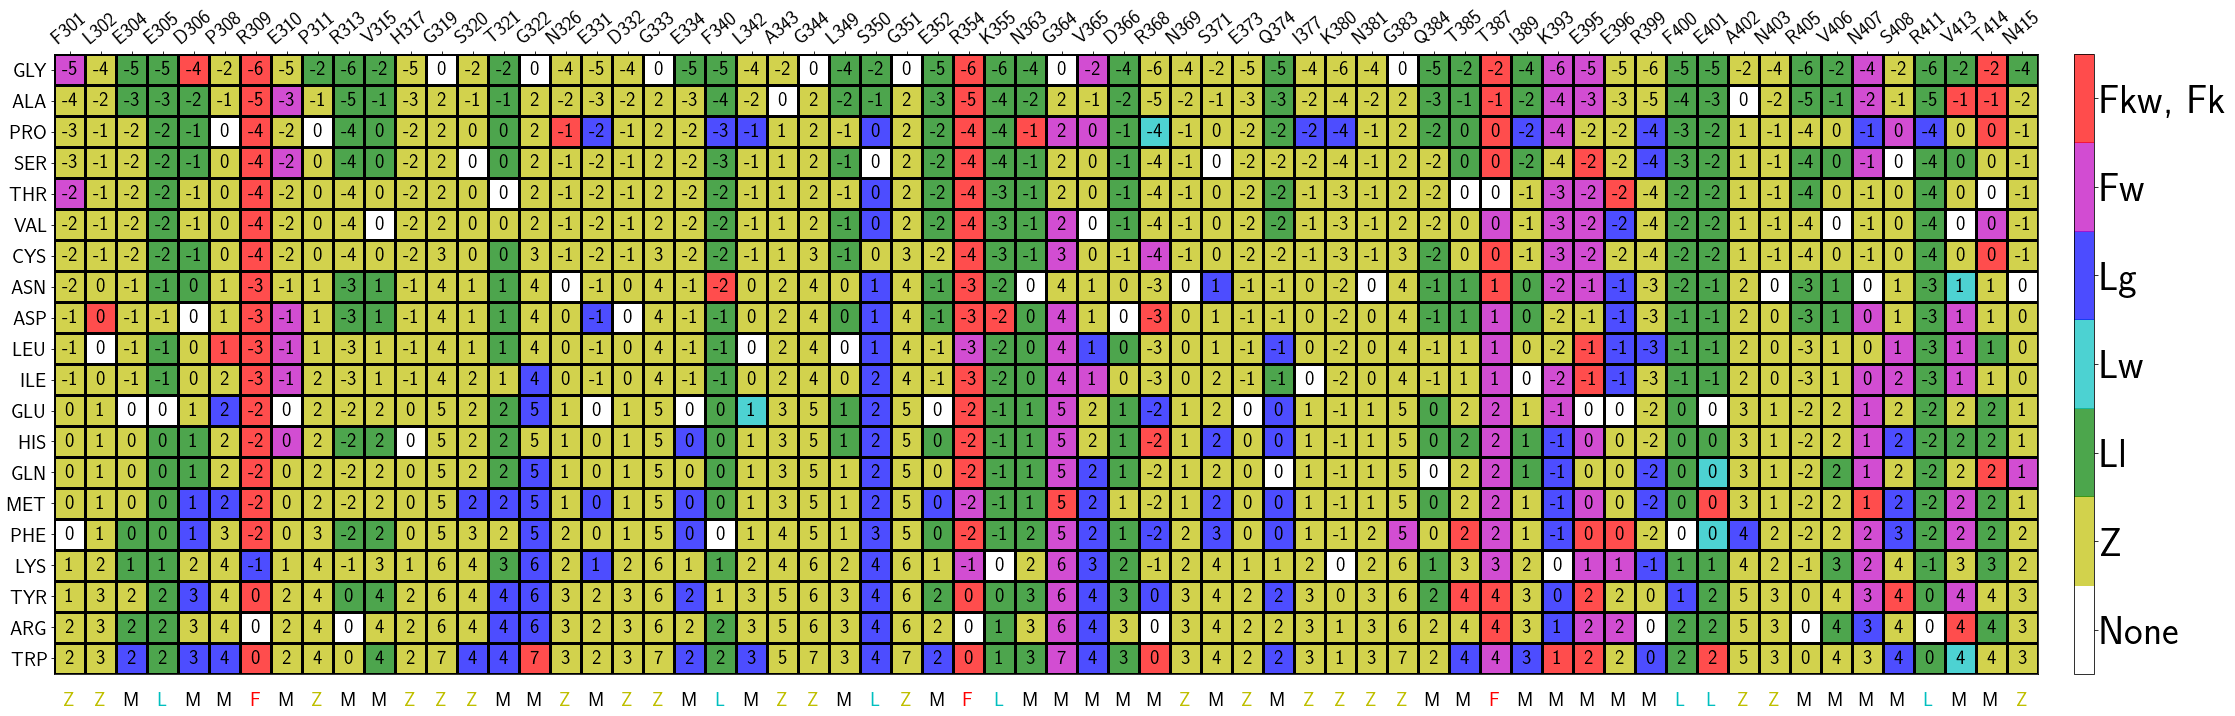

In [25]:
# Surface-exposed residues

fig, ax = plt.subplots(figsize=(60, 10))
im = ax.imshow(Mn[surface].values, cmap=cmap, alpha=0.7)


# Loop over data dimensions and create text annotations.
for i in range(len(Mdist[surface].values)):
    for j in range(len(Mdist[surface].values[i])):
        if M[surface].to_numpy()[i][j]:
            text = ax.text(j, i, Mdist[surface].values[i, j],
                           ha="center", va="center", color="k", fontsize=20)

ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=20)

ax.set_xticks(np.arange(Mn[surface].values.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(Mn[surface].values.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="k", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=.5)

values=np.arange(-.5, 6, 1)
cbar = fig.colorbar(im, cax=cax, ticks=values)

cbar.ax.set_yticklabels(["None", "Z", "Ll", "Lw", "Lg", "Fw", "Fkw, Fk"], fontsize=40)
ax.set_xticks(range(len(Mn[surface].columns)))
ax.set_xticklabels(aaseq_surf, rotation=40, )
ax.set_yticks(range(len(Mn[surface].index)))
ax.set_yticklabels(Mn[surface].index)

for i, (aa, s) in enumerate(M_approx_describe[surface].loc['class'].iteritems()):
    if s == 'Z':
        c = 'y'
    elif s == 'L':
        c = 'c'
    elif s == 'F':
        c = 'r'
    else:
        c = 'k'
    ax.text(i, 20.5, s, fontsize=20, horizontalalignment='center', c=c)

plt.tight_layout()
plt.savefig(os.path.join(folder_path, "matrix_surface.pdf"))
plt.show()

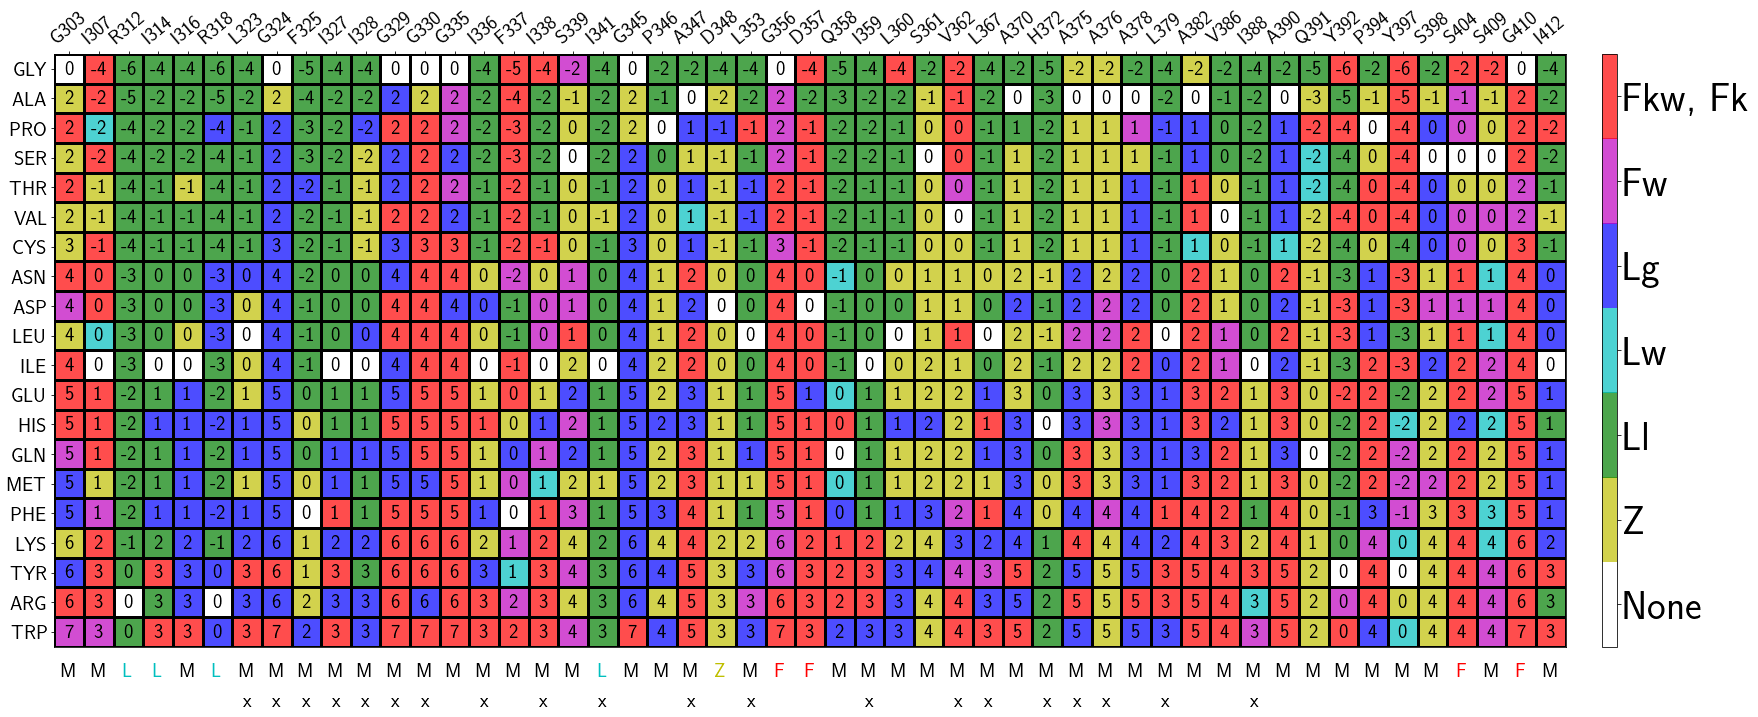

In [26]:
# Buried residues

fig, ax = plt.subplots(figsize=(60, 10))
im = ax.imshow(Mn[buried].values, cmap=cmap, alpha=0.7)


# Loop over data dimensions and create text annotations.
for i in range(len(Mdist[buried].values)):
    for j in range(len(Mdist[buried].values[i])):
        if M[buried].to_numpy()[i][j]:
            text = ax.text(j, i, Mdist[buried].values[i, j],
                           ha="center", va="center", color="k", fontsize=20)

ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=20)

ax.set_xticks(np.arange(Mn[buried].values.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(Mn[buried].values.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="k", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=.5)

values=np.arange(-.5, 6, 1)
cbar = fig.colorbar(im, cax=cax, ticks=values)

cbar.ax.set_yticklabels(["None", "Z", "Ll", "Lw", "Lg", "Fw", "Fkw, Fk"], fontsize=40)
ax.set_xticks(range(len(Mn[buried].columns)))
ax.set_xticklabels(aaseq_buried, rotation=40, )
ax.set_yticks(range(len(Mn[buried].index)))
ax.set_yticklabels(Mn[buried].index)

for i, (aa, s) in enumerate(M_approx_describe[buried].loc['class'].iteritems()):
    if s == 'Z':
        c = 'y'
    elif s == 'L':
        c = 'c'
    elif s == 'F':
        c = 'r'
    else:
        c = 'k'
    ax.text(i, 20.5, s, fontsize=20, horizontalalignment='center', c=c)
    
    if aa in fsp:
        ax.text(i, 21.5, "x", fontsize=20, horizontalalignment='center')

plt.tight_layout()
plt.savefig(os.path.join(folder_path, "matrix_buried.pdf"))
plt.show()

# GCAT network

We say that an amino acid i perturbs an amino acid j, with $j \neq i$, if there
exists a mutation of the amino acid in position $i$ that causes a change in the neighborhood of the
amino acid in position $j$ in the mutant's AAN, compared to the AAN of the wild-type, in terms of
list of neighbors (i.e, ignoring the weights of interactions).

Then, the GCAT network is defined as follows:
The GCAT network of a protein is represented by a weighted directed graph $G(V;E)$
with $V$ its set of nodes and $E$ its set of arcs, where:
- $V$ is the set of amino acids of the protein;
- An arc $(i; j) \in E$ if $i$ perturbs $j$;
- Each arc $(i; j) \in E$ is associated to a weight $w_{ij}$ equal to the strength of the perturbation from
node $i$ to node $j$

In [27]:
G = nx.DiGraph()
for pdb in pdbs:
    if pdb in allP:
        P = allP[pdb]
        v = 'A' + pdb[5:-1]
        for n in P.keys():
            pert = len(np.array(P[n]['tot']))
            if n != v and pert > 0: # ignore self-edges (node perturbes itself)
                if v not in G.nodes or n not in G.neighbors(v):
                    G.add_edge(v, n)

Add FSP attribute (True or False)

In [28]:
fsp_attr = {n: True if n in fsp else False for n in G.nodes}
nx.set_node_attributes(G, fsp_attr, "fsp")

Add surface attribute (True or False)

In [29]:
surf_attr = {n: True if n in surface else False for n in G.nodes}
nx.set_node_attributes(G, surf_attr, "surface")

In [30]:
#list degrees along the sequence
indegree = dict(G.in_degree())
outdegree = dict(G.out_degree())
kin_av = np.average(list(indegree.values()))
kout_av = np.average(list(outdegree.values()))
print("average in-degree:", kin_av)
print("average out-degree:", kout_av)

# ACUTALLY KIN = KOUT BY DEFINITION!

average in-degree: 7.04424778761062
average out-degree: 7.04424778761062


Classify nodes as "Connect", "Absorb", "Generate" or "Transmit" based on their in- and out-degree:

In [31]:
GCAT = {}
for n in G.nodes:
    if indegree[n] <= kin_av:
        if outdegree[n] <= kout_av:
            GCAT[n] = "C"
        else:
            GCAT[n] = "G"
    elif outdegree[n] <= kout_av:
        GCAT[n] = "A"
    else:
        GCAT[n] = "T"
nx.set_node_attributes(G, GCAT, "GCAT")

K-cores

In [32]:
nodes_kcores = nx.algorithms.core.core_number(G)

In [33]:
nx.set_node_attributes(G, nodes_kcores, "kcore")

In [34]:
kcores = {}
for k in set(nodes_kcores.values()):
    kcores[k] = [n for n in G.nodes if nodes_kcores[n] == k]

## Export the GCAT network

In [35]:
# save GCAT edge list
nx.write_edgelist(G, os.path.join(folder_path, "GCAT_edgelist.csv"))

In [49]:
# save GCAT nodes info
nodes_data = []
for n in G.nodes:
    kin = G.in_degree(n)
    kout = G.out_degree(n)
    c = GCAT[n]
    is_fsp = n in fsp
    is_surface = n in surface
    num_kcore = nodes_kcores[n]
    in_neighbors = list(G.predecessors(n))
    out_neighbors = list(G.neighbors(n))
    info = [n, kin, kout, c, is_fsp, is_surface, num_kcore, in_neighbors, out_neighbors]
    nodes_data.append(info)
nodes_data = pd.DataFrame(nodes_data, columns=["node", "kin", "kout", "GCAT", "fsp", "surface", "kcore", "in_neighbors", "out_neighbors"])
nodes_data.to_csv(os.path.join(folder_path, "GCAT_nodes.csv"), index=False)

In [37]:
pickle.dump(G, open(os.path.join(folder_path, 'GCAT.p'), 'wb'))

In [38]:
#save graph as gexf to read it with gephi
nx.write_gexf(G, os.path.join(folder_path, 'GCAT_net.gexf'))